In [1]:
import os

import numpy as np
import pandas as pd

%pylab inline
%config InlineBackend.figure_format='svg'

Populating the interactive namespace from numpy and matplotlib


# Gradient descent

Gradient descent (GD) is a **first-order iterative optimization algorithm** for finding a **local minimum** of a **differentiable function**. Each GD iteration moves the trainable parameters in the direction of the steepest descent of the loss function.

Consider a machine learning problem formulated as an empirical risk minimization problem:
$$\min_w {\hat{\mathcal{R}}(w,X,Y)},$$
where $w$ is a vector of **trainable parameters** and (X,Y) is the dataset. Then the GD algoritm on this problem consist of the following steps:

0. Choose **hyperparameters**: learning rate $\eta\in\mathbb{R}$, number of epochs $K\in\mathbb{N}$.
1. **Initialize** trainable parameters $w^{(0)}$. Set $k=0$. 
   
2. **While** k < K: 
    - Run a GD update:\
    $w^{(k+1)} = w^{(k)} - \eta \nabla_w \hat{\mathcal{R}}(w^{(k)},X,Y)$
    - Update k:\
    $k = k+1$
3. **Return** $w^{(K)}$.

## Properties

 - GD with a **sufficiently small learning rate** is guaranteed to converge to the minimum of a **convex function**.

 - There are very few guarantees for GD on non-convex functions. In most realistic situations, properly set up GD converges to a local minimum in this case. 
 
 - GD does not always converge! Improper choice of learning rate can lead to divergence even on convex functions.
 
Let us consider an example: minimization of a two-dimensional **quadratic function** with GD.
$$\min_x{\dfrac{1}{2}x^TAx},$$
where $A\in\mathbb{R}^{2\times 2}, x\in\mathbb{R}^{2}$. We define a class of such objective function and their corresponding gradients:

In [2]:
class quadratic_form():
    def __init__(self,A):
        self.A = A
    def val(self, x):
        return 0.5*x.T@self.A@x
    
    def grad(self, x):
        return self.A@x

First we choose a well-conditioned matrix: 
$$A =\begin{bmatrix} 
	1 & 0 \\
	0 & 1 \\
	\end{bmatrix}$$
and observe how GD performs on this problem. We compare behavior with several learning rate values.

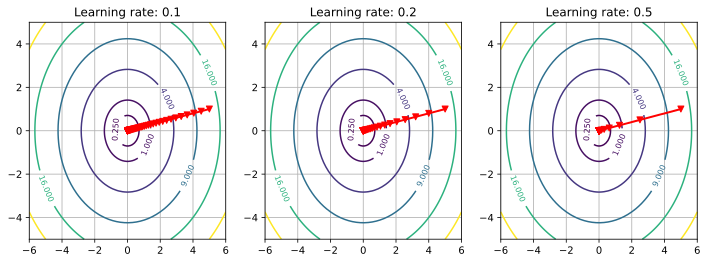

In [3]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

f = quadratic_form(np.array([[1,0],[0,1]]))

xrange = [-6, 6]
yrange = [-5, 5]
levels = [0, 0.25, 1, 4, 9, 16, 25]
        
x = np.linspace(xrange[0], xrange[1], 100)
y = np.linspace(yrange[0], yrange[1], 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = f.val(np.array([X[i, j], Y[i, j]]))

### Hyperparameters:
K = 100
lr_s = [0.1,0.2,0.5]
###

for ax_,lr in zip(ax,lr_s):
    
    CS = ax_.contour(X, Y, Z, levels=levels)
    ax_.clabel(CS, inline=1, fontsize=8) 
    ax_.grid()  
    
    x = np.array([5,1])
    history = [x]

    for k in range(K):
        x = x - lr*f.grad(x)
        history.append(x)

    history = np.array(history)
    ax_.plot(history[:,0],history[:,1],'-v', color='red', linewidth=2)
    ax_.set_title('Learning rate: '+str(lr))
    ax_.set_xlim(xrange)
    ax_.set_ylim(yrange)

Now we choose a not-so-well-conditioned matrix: 
$$A =\begin{bmatrix} 
	1 & 0 \\
	0 & 10 \\
	\end{bmatrix}$$
and, once again, observe GD behaviour with several learning rate values.

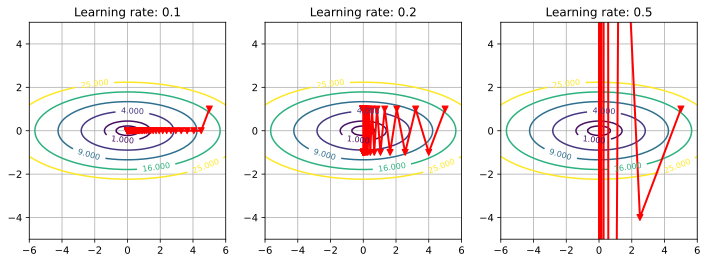

In [4]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

f = quadratic_form(np.array([[1,0],[0,10]]))

xrange = [-6, 6]
yrange = [-5, 5]
levels = [0, 0.25, 1, 4, 9, 16, 25]
        
x = np.linspace(xrange[0], xrange[1], 100)
y = np.linspace(yrange[0], yrange[1], 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = f.val(np.array([X[i, j], Y[i, j]]))

### Hyperparameters:
K = 100
lr_s = [0.1,0.2,0.5]
###

for ax_,lr in zip(ax,lr_s):
    
    CS = ax_.contour(X, Y, Z, levels=levels)
    ax_.clabel(CS, inline=1, fontsize=8) 
    ax_.grid()  
    
    x = np.array([5,1])
    history = [x]

    for k in range(K):
        x = x - lr*f.grad(x)
        history.append(x)

    history = np.array(history)
    ax_.plot(history[:,0],history[:,1],'-v', color='red', linewidth=2)
    ax_.set_title('Learning rate: '+str(lr))
    ax_.set_xlim(xrange)
    ax_.set_ylim(yrange)

We see that GD does not converge on a convex function in this example if the learning rate value is too large. 
In the graphs, we see a typical **"zigzagging" behavior**.

In convex optimization literature, there are multiple strategies to choose a learning rate value in GD, which provie (stronger or weaker) theoretical guarantees for convergence. Well-known examples are [Wolfe conditions](https://en.wikipedia.org/wiki/Wolfe_conditions) and [Backtracking](https://en.wikipedia.org/wiki/Backtracking_line_search). However, these methods are computationally expensive and are not very common in modern ML. 

In ML applications, it is more common to use so-called **adaptive optimization methods** that adjust the learning rate in each GD step based on the resent history of updates. Such methods are generalizations of GD and we will consider them later in the course.

## Binary classification with GD

### Load the data:

In [5]:
file_name = 'iris_data_set.csv'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
column_names = ['sepal length [cm]', 'sepal width [cm]',
                'petal length [cm]', 'petal width [cm]', 'iris type']

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name, index_col=0)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url, names=column_names)
    df.to_csv(file_name)
    print('Done.')

Loading data from local file `iris_data_set.csv`...


In [6]:
df

,sepal length [cm],sepal width [cm],petal length [cm],petal width [cm],iris type
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


### Assign class labels:

In [7]:
df['class'] = df['iris type'].replace(
    ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'],
    [-1, 1, 1])

### Train-test split 

In [8]:
def  train_test_split(df, training_data_fraction, shuffle=True):
    '''
    Split all available data into a training and test data set.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame of available data.
    training_data_fraction : float
        The fraction of the data that should be used for training.
        E.g., `training_data_fraction=0.6` means 60%.
    shuffle : bool , optional
        If True, randomly reshuffles the data before the split.
    '''
    
    if shuffle is True:
        df_ = df.sample(frac=1).reset_index(drop=True)
    else:
        df_= df
    
    train_df = df_.iloc[:round(training_data_fraction*len(df_)),:]
    test_df = df_.iloc[round(training_data_fraction*len(df_)):,:]
    
    return df_, train_df, test_df

In [9]:
training_data_fraction = .8

df, train_df, test_df =  train_test_split(df, training_data_fraction)

# convert DataFrame entries to Numpy arrays
# `X, Y`: all data
# `train_X, train_Y`: training data
# `test_X, test_Y`: training data

X = df[['sepal length [cm]', 'petal width [cm]']].to_numpy()
Y = df['class'].to_numpy()

train_X = train_df[['sepal length [cm]', 'petal width [cm]']].to_numpy()
train_Y = train_df['class'].to_numpy()

test_X = test_df[['sepal length [cm]', 'petal width [cm]']].to_numpy()
test_Y = test_df['class'].to_numpy()

print('Training data split as follows:')
print(f'  Training data samples: {len(train_df)}')
print(f'      Test data samples: {len(test_df)}')

Training data split as follows:
  Training data samples: 120
      Test data samples: 30


### Plot the data

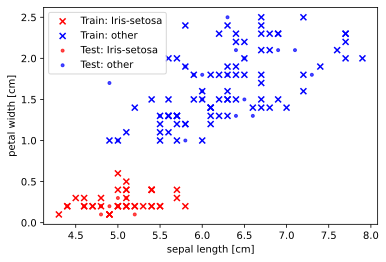

In [10]:
fig, ax = plt.subplots()

train_X_minus1 = train_X[train_Y == -1]
plt.scatter(train_X_minus1[:, 0], train_X_minus1[:, 1], marker='x', color='red', label='Train: Iris-setosa')

train_X_plus1 = train_X[train_Y == +1]
plt.scatter(train_X_plus1[:, 0], train_X_plus1[:, 1], marker='x', color='blue', label='Train: other')

test_X_minus1 = test_X[test_Y == -1]
test_X_plus1 = test_X[test_Y == +1]
plt.scatter(test_X_minus1[:, 0], test_X_minus1[:, 1], marker='.', color='red', label='Test: Iris-setosa', alpha=.7)
plt.scatter(test_X_plus1[:, 0], test_X_plus1[:, 1], marker='.', color='blue', label='Test: other', alpha=.7)

plt.xlabel('sepal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend()

### Define a binary classification class

We will define the hypothesis $h_{w,b}(x)=\text{sign}(w\cdot x+b)$ as a
Python class to keep track of the internal weight vector $w$ and bias term
$b$. Compared to the previos classes, we will add a train() method to the class, which performs optimization with GD. 

Our optimization problem is  $$\min_{w,b}\dfrac{1}{2N}\|Xw+b\mathbb{1}_N - Y\|^2_2 = \min_{w,b}\dfrac{1}{2N} \sum_{i=1}^N (\langle x_i, w \rangle + b - y_i)^2$$
And the gradients are given by:
$$\nabla_w \hat{\mathcal{R}}(w,X,Y) = \dfrac{1}{N}X^T (Xw+b\mathbb{1}_N - Y)  = \dfrac{1}{N} \sum_{i=1}^N ( \langle x_i, w \rangle + b - y_i) * x_i$$
$$\nabla_b \hat{\mathcal{R}}(w,X,Y) = \dfrac{1}{N}\mathbb{1}_N^T (Xw+b\mathbb{1}_N - Y) = \dfrac{1}{N} \sum_{i=1}^N ( \langle x_i, w \rangle + b - y_i) $$

We need to implement these equations in the training method.

In [11]:
class LinearBinaryClassification:

    def __init__(self, w, b):
        self._w = np.array(w, dtype=np.float)
        self._b = np.array(b, dtype=np.float)
        self.history = [{'w': self._w.copy(),
                         'b': self._b.copy(),
                         'loss': None,
                         'accuracy': None}]
        
    def h(self, x):
        # Numpy's `where` function provides a fast substitution
        return np.where(x @ self._w + self._b >= 0.0, 1, -1)
    
    def accuracy(self, X, Y):
        return 1. - np.sum(self.h(X) != Y)/Y.size
    
    def loss(self, X, Y):
        ones_vec = np.ones(X.shape[0])
        return 0.5/X.shape[0]*np.dot(X@self._w + self._b*ones_vec - Y,
                          X@self._w + self._b*ones_vec - Y)
    
    def loss_grad(self, X,Y):
        ones_vec = np.ones(X.shape[0])
        return X.T@(X@self._w + self._b*ones_vec - Y)/X.shape[0], ones_vec.T@(X@self._w 
                                                                    + self._b*ones_vec - Y)/X.shape[0]
    
    def train(self, X, Y, lr = 1e-3, num_iter = 100):
        
        self.history[0]['loss'] = self.loss(X,Y)
        self.history[0]['accuracy'] = self.accuracy(X,Y)
        
        for e in range(num_iter):
            
            grad_w, grad_b = self.loss_grad(X,Y)
            self._w -= lr*grad_w
            self._b -= lr*grad_b
            
            self.history.append({'w': self._w.copy(),
                                 'b': self._b.copy(),
                                 'loss': self.loss(X,Y),
                                 'accuracy': self.accuracy(X,Y)})
            
        return self._w, self._b


### Train a model and plot the results

In [12]:
w = np.array([0, 0])
b = 0

model = LinearBinaryClassification(w, b)
model.train(train_X,train_Y, lr=1e-3, num_iter=5000)

(array([-0.11450456,  1.03738103]), array(-0.21658183))

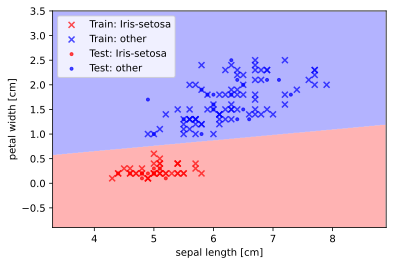

In [13]:
fig, ax = plt.subplots()

x1_min = train_X[:, 0].min() - 1
x1_max = train_X[:, 0].max() + 1
x2_min = train_X[:, 1].min() - 1
x2_max = train_X[:, 1].max() + 1

x1_list, x2_list = np.meshgrid(np.arange(x1_min, x1_max, .01), 
                               np.arange(x2_min, x2_max, .01))

X_list = np.dstack([x1_list, x2_list])
h_list = model.h(X_list)

cmap = matplotlib.colors.ListedColormap(['red', 'blue'])
plt.contourf(x1_list, x2_list, h_list, cmap=cmap, alpha=.3)

plt.scatter(train_X_minus1[:, 0], train_X_minus1[:, 1], marker='x', color='red', label='Train: Iris-setosa', alpha=.7)
plt.scatter(train_X_plus1[:, 0], train_X_plus1[:, 1], marker='x', color='blue', label='Train: other', alpha=.7)

plt.scatter(test_X_minus1[:, 0], test_X_minus1[:, 1], marker='.', color='red', label='Test: Iris-setosa', alpha=.7)
plt.scatter(test_X_plus1[:, 0], test_X_plus1[:, 1], marker='.', color='blue', label='Test: other', alpha=.7)

plt.xlabel('sepal length [cm]')
plt.xlim(x1_min, x1_max)
plt.ylabel('petal width [cm]')
plt.ylim(x2_min, x2_max)
plt.legend()

### Learning curve

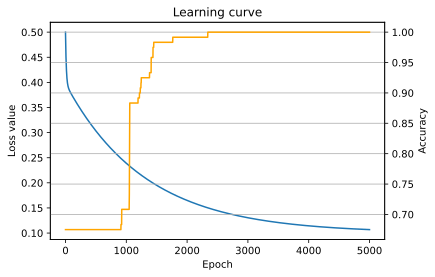

In [14]:
fig, ax = plt.subplots()

loss_history = [h['loss'] for h in model.history]
acc_history = [h['accuracy'] for h in model.history]

ax.plot(range(len(model.history)), loss_history)
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(model.history)), acc_history, color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

## Exercise: Stochastic GD

In case the dataset is large, it is challenging to compute the loss gradient on the whole dataset at every optimization step. Therefore, the dataset is typically separated into small **batches** and each update is performed only over a single batch. One of the most common algorithms to perform this is called **Stochastic Gradient Descent (SGD)**, which performs an update on every data sample individually:

0. Choose **hyperparameters**: learning rate $\eta\in\mathbb{R}$, number of epochs $K\in\mathbb{N}$.
1. **Initialize** trainable parameters $w^{(0)}$. Set $k=0$. 
   
2. **While** k < K: 
    
- **For** every x_i in X:
    - Run a GD update: $$w^{new} = w - \eta \nabla_w \mathcal{R}(w,x_i,y_i)$$
    - Set $w=w^{new}$
  
- Update k:\
    $k = k+1$
    
3. **Return** $w^{(K)}$.

Implement SGD inside our linear binary classification class. Train a model with SGD and plot a learning curve. How does it compare to the full-batch GD curve?